# Univariate Data Analysis using Facebook Prophet Model
Prophet is a procedure for forecasting time series data based on an additive model where non-linear trends are fit with yearly, weekly, and daily seasonality, plus holiday effects.
Prophet is open source software released by Facebook’s Core Data Science team.

Univariate analysis can be applied to stock price data to understand the characteristics of the stock's price movements over a certain period of time.

In [1]:
from prophet import Prophet
import yfinance as yf
import numpy as np
from datetime import date
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import itertools
from prophet.plot import plot_plotly
from prophet.plot import add_changepoints_to_plot
from plotly import graph_objs as go

## Create Dataframe

In [2]:
df = yf.Ticker('AMZN').history(start = '2020-01-01')
#.history('max')
#end =
#(start = '2011-01-01', end ='2023-12-31')
df.info()


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1093 entries, 2020-01-02 00:00:00-05:00 to 2024-05-06 00:00:00-04:00
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Open          1093 non-null   float64
 1   High          1093 non-null   float64
 2   Low           1093 non-null   float64
 3   Close         1093 non-null   float64
 4   Volume        1093 non-null   int64  
 5   Dividends     1093 non-null   float64
 6   Stock Splits  1093 non-null   float64
dtypes: float64(6), int64(1)
memory usage: 68.3 KB


In [3]:
df

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2020-01-02 00:00:00-05:00,93.750000,94.900497,93.207497,94.900497,80580000,0.0,0.0
2020-01-03 00:00:00-05:00,93.224998,94.309998,93.224998,93.748497,75288000,0.0,0.0
2020-01-06 00:00:00-05:00,93.000000,95.184502,93.000000,95.143997,81236000,0.0,0.0
2020-01-07 00:00:00-05:00,95.224998,95.694504,94.601997,95.343002,80898000,0.0,0.0
2020-01-08 00:00:00-05:00,94.902000,95.550003,94.321999,94.598503,70160000,0.0,0.0
...,...,...,...,...,...,...,...
2024-04-30 00:00:00-04:00,181.089996,182.990005,174.800003,175.000000,94639800,0.0,0.0
2024-05-01 00:00:00-04:00,181.639999,185.149994,176.559998,179.000000,94645100,0.0,0.0
2024-05-02 00:00:00-04:00,180.850006,185.100006,179.910004,184.720001,54303500,0.0,0.0


## Splitting the Data

In [4]:
train_val_split_date = '2022-10-01'
val_test_split_date = '2023-10-01'

df_train = df.loc[df.index <= train_val_split_date].copy()

df_val = df.loc[df.index >= train_val_split_date].copy()
df_val = df_val[df_val.index < val_test_split_date]
df_val

df_test = df.loc[df.index > val_test_split_date].copy()

# We only want the closing prices
df_train = pd.DataFrame(df_train.Close)
df_val = pd.DataFrame(df_val.Close)
df_test = pd.DataFrame(df_test.Close)

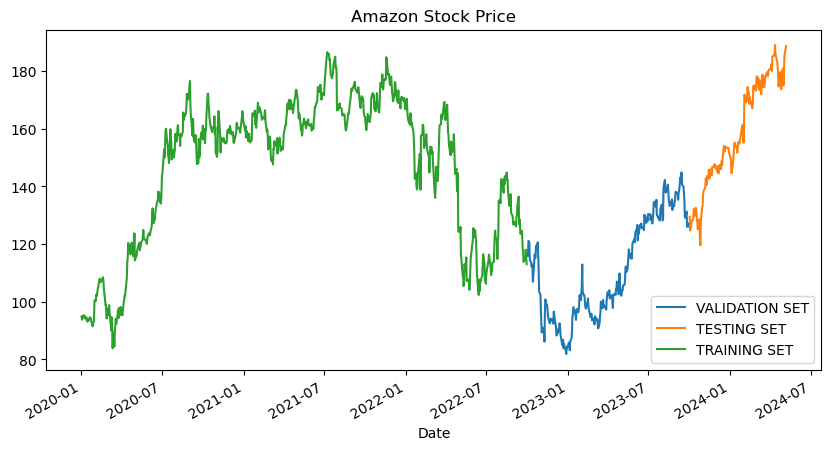

In [5]:
#Changing the column names for join

df_val \
    .rename(columns={'Close': 'VALIDATION SET'}) \
    .join(df_test.rename(columns={'Close': 'TESTING SET'}),
          how='outer') \
    .join(df_train.rename(columns={'Close': 'TRAINING SET'}),
          how='outer') \
    .plot(figsize=(10, 5), title='Amazon Stock Price', ms=1)
plt.show()

In [6]:
# Prophet model requires the dataset to be in a specific name, refer to prophet library documentation
df_train = df_train.reset_index() \
    .rename(columns={'Date':'ds',
                     'Close':'y'})

df_val = df_val.reset_index() \
    .rename(columns={'Date':'ds',
                     'Close':'y'})

df_test = df_test.reset_index() \
    .rename(columns={'Date':'ds',
                     'Close':'y'})

#Trading days are only Monday to Friday
df_train = df_train[df_train['ds'].dt.dayofweek < 5]
df_val = df_val[df_val['ds'].dt.dayofweek < 5]
df_test = df_test[df_test['ds'].dt.dayofweek < 5]

#model requires timezone from timestamp column to be removed
df_train['ds'] =  df_train['ds'].apply(lambda x: x.replace(tzinfo=None))
df_val['ds'] =  df_val['ds'].apply(lambda x: x.replace(tzinfo=None))
df_test['ds'] =  df_test['ds'].apply(lambda x: x.replace(tzinfo=None))


## Train the model

In [7]:
model = Prophet()

In [8]:
model = Prophet()
df_train_fcst = model.fit(df_train).predict(df_train)

17:28:07 - cmdstanpy - INFO - Chain [1] start processing
17:28:08 - cmdstanpy - INFO - Chain [1] done processing


C:\Users\zhesh\anaconda3\Lib\site-packages\prophet\plot.py:72: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  fcst_t = fcst['ds'].dt.to_pydatetime()
C:\Users\zhesh\anaconda3\Lib\site-packages\prophet\plot.py:73: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  ax.plot(m.history['ds'].dt.to_pydatetime(), m.history['y'], 'k.',


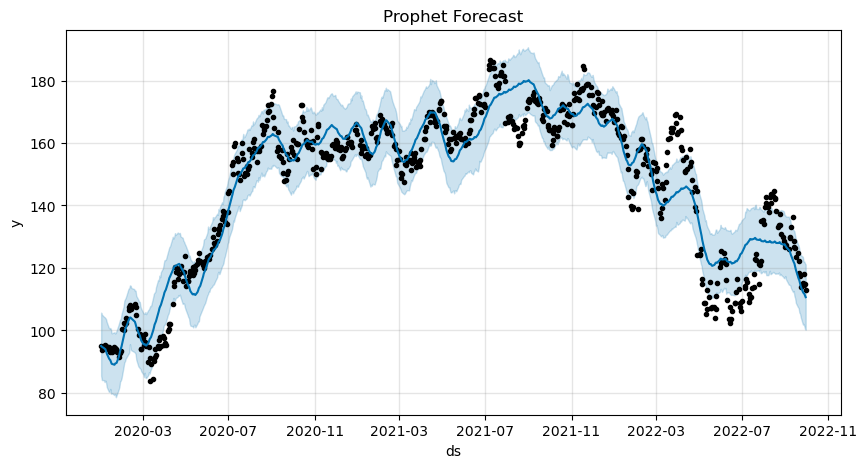

In [9]:
fig, ax = plt.subplots(figsize=(10, 5))
fig = model.plot(df_train_fcst, ax=ax)
#a = add_changepoints_to_plot(fig.gca(), model, df_train_fcst)

ax.set_title('Prophet Forecast')
plt.show()

C:\Users\zhesh\anaconda3\Lib\site-packages\prophet\plot.py:228: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  fcst_t = fcst['ds'].dt.to_pydatetime()
C:\Users\zhesh\anaconda3\Lib\site-packages\prophet\plot.py:351: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  df_y['ds'].dt.to_pydatetime(), seas[name], ls='-', c='#0072B2')
C:\Users\zhesh\anaconda3\Lib\site-packages\prophet\plot.py:354: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np

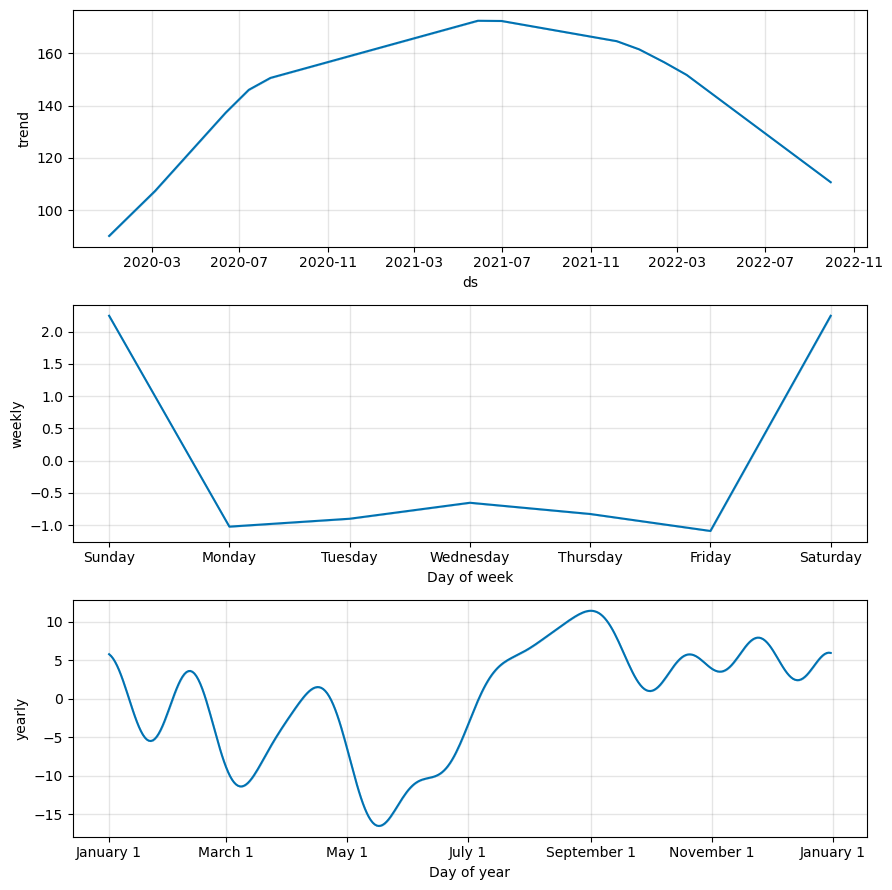

In [10]:
model.plot_components(df_train_fcst)
plt.show()

## Validation Check

In [11]:
# Create new dataframe for prediction
# note: 'include_history' only includes the dates of the training set and not the 'y'.
val_future = model.make_future_dataframe(periods=365, freq='d', include_history=True)

In [12]:
val_future

,ds
0,2020-01-02
1,2020-01-03
2,2020-01-06
3,2020-01-07
4,2020-01-08
...,...
1053,2023-09-26
1054,2023-09-27
1055,2023-09-28
1056,2023-09-29


In [13]:
val_fcst = model.predict(val_future)

In [14]:
val_fcst

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2020-01-02,90.132953,85.461953,104.974726,90.132953,90.132953,4.925837,4.925837,4.925837,-0.827384,-0.827384,-0.827384,5.753221,5.753221,5.753221,0.0,0.0,0.0,95.058789
1,2020-01-03,90.402720,84.515571,104.787414,90.402720,90.402720,4.403059,4.403059,4.403059,-1.090959,-1.090959,-1.090959,5.494018,5.494018,5.494018,0.0,0.0,0.0,94.805779
2,2020-01-06,91.212023,84.893079,104.614334,91.212023,91.212023,3.158716,3.158716,3.158716,-1.023742,-1.023742,-1.023742,4.182458,4.182458,4.182458,0.0,0.0,0.0,94.370739
3,2020-01-07,91.481790,84.261400,105.252866,91.481790,91.481790,2.683458,2.683458,2.683458,-0.901219,-0.901219,-0.901219,3.584678,3.584678,3.584678,0.0,0.0,0.0,94.165249
4,2020-01-08,91.751558,83.978095,103.829267,91.751558,91.751558,2.267512,2.267512,2.267512,-0.653315,-0.653315,-0.653315,2.920827,2.920827,2.920827,0.0,0.0,0.0,94.019070
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1053,2023-09-26,36.615969,13.014374,62.276293,14.593546,59.983005,1.058090,1.058090,1.058090,-0.901219,-0.901219,-0.901219,1.959309,1.959309,1.959309,0.0,0.0,0.0,37.674059
1054,2023-09-27,36.410751,12.681280,62.779614,14.340588,59.900234,0.990098,0.990098,0.990098,-0.653315,-0.653315,-0.653315,1.643413,1.643413,1.643413,0.0,0.0,0.0,37.400850
1055,2023-09-28,36.205534,10.886681,62.588959,14.087631,59.817464,0.561960,0.561960,0.561960,-0.827384,-0.827384,-0.827384,1.389344,1.389344,1.389344,0.0,0.0,0.0,36.767494
1056,2023-09-29,36.000317,10.171562,61.882416,13.818729,59.681784,0.109390,0.109390,0.109390,-1.090959,-1.090959,-1.090959,1.200349,1.200349,1.200349,0.0,0.0,0.0,36.109707


C:\Users\zhesh\anaconda3\Lib\site-packages\prophet\plot.py:72: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  fcst_t = fcst['ds'].dt.to_pydatetime()
C:\Users\zhesh\anaconda3\Lib\site-packages\prophet\plot.py:73: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  ax.plot(m.history['ds'].dt.to_pydatetime(), m.history['y'], 'k.',


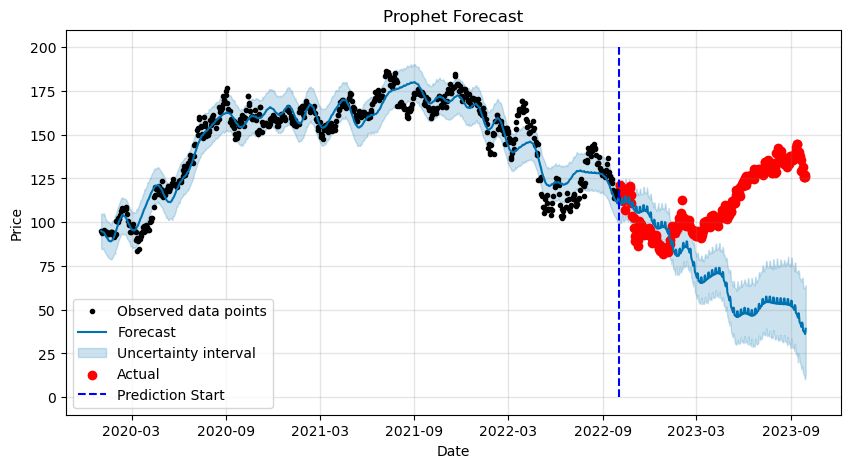

In [15]:
fig, ax = plt.subplots(figsize=(10, 5))
fig = model.plot(val_fcst, ax=ax)
ax.scatter( df_val['ds'], df_val['y'], color='r', label = 'Actual')
ax.set_title('Prophet Forecast')

plt.vlines(x=min(df_val['ds']).date(), ymin=0, ymax=200, colors = 'b',
                       linestyles='dashed', label = 'Prediction Start')
plt.xlabel("Date")
plt.ylabel("Price")
plt.legend()


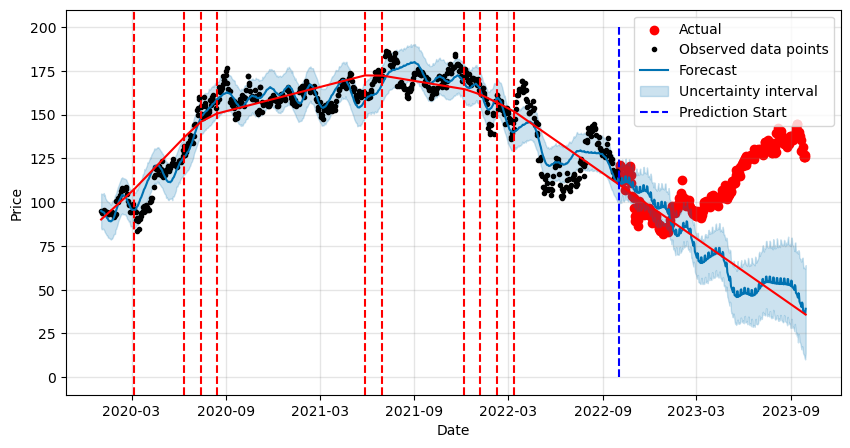

In [16]:
f, ax = plt.subplots(figsize=(10, 5))
ax.scatter( df_val['ds'], df_val['y'], color='r', label = 'Actual')
fig = model.plot(val_fcst, ax=ax)
a = add_changepoints_to_plot(fig.gca(), model, val_fcst)

plt.vlines(x=min(df_val['ds']).date(), ymin=0, ymax=200, colors = 'b',
                       linestyles='dashed', label = 'Prediction Start')
plt.xlabel("Date")
plt.ylabel("Price")
plt.legend()
plt.show()

C:\Users\zhesh\anaconda3\Lib\site-packages\prophet\plot.py:228: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  fcst_t = fcst['ds'].dt.to_pydatetime()
C:\Users\zhesh\anaconda3\Lib\site-packages\prophet\plot.py:351: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  df_y['ds'].dt.to_pydatetime(), seas[name], ls='-', c='#0072B2')
C:\Users\zhesh\anaconda3\Lib\site-packages\prophet\plot.py:354: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np

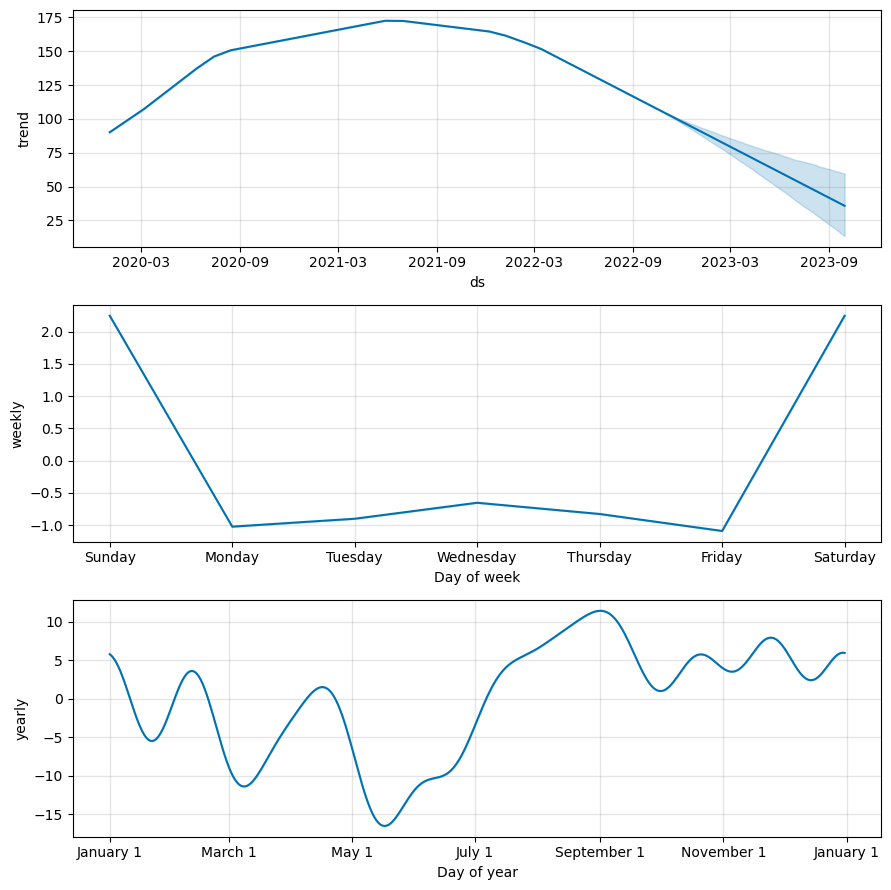

In [17]:
model.plot_components(val_fcst)
plt.show()

## Model Parameters

### Trend Changepoints

By default, Prophet will automatically detect these changepoints and will allow the trend to adapt appropriately.

If the trend changes are being overfit (too much flexibility) or underfit (not enough flexibility), 
you can adjust the strength of the sparse prior using the input argument changepoint_prior_scale. 

By default, this parameter is set to 0.05. Increasing it will make the trend more flexible and vise versa.

17:28:09 - cmdstanpy - INFO - Chain [1] start processing
17:28:09 - cmdstanpy - INFO - Chain [1] done processing
17:28:09 - cmdstanpy - INFO - Chain [1] start processing
17:28:09 - cmdstanpy - INFO - Chain [1] done processing
17:28:09 - cmdstanpy - INFO - Chain [1] start processing
17:28:09 - cmdstanpy - INFO - Chain [1] done processing
17:28:09 - cmdstanpy - INFO - Chain [1] start processing
17:28:10 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\zhesh\anaconda3\Lib\site-packages\prophet\plot.py:72: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  fcst_t = fcst['ds'].dt.to_pydatetime()
C:\Users\zhesh\anaconda3\Lib\site-packages\prophet\plot.py:73: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing pyth

Text(0.5, 1.0, 'Change Point Scale: 0.5')

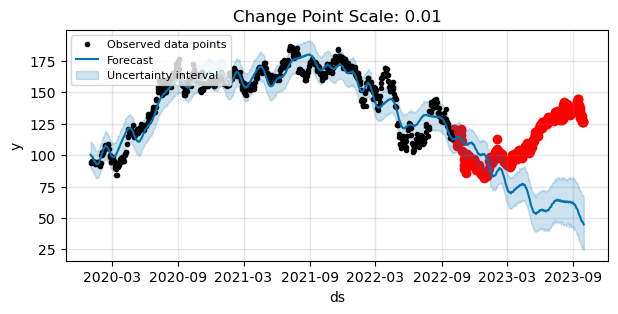

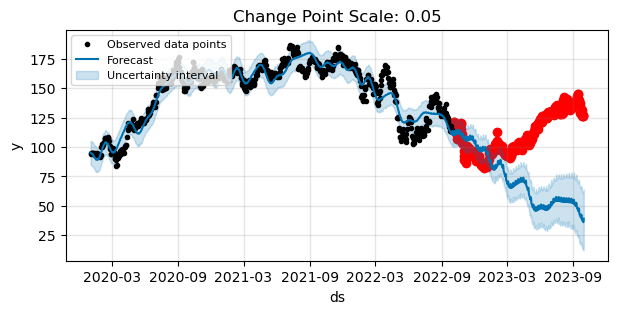

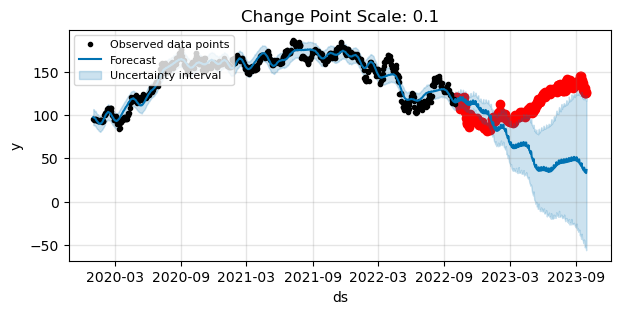

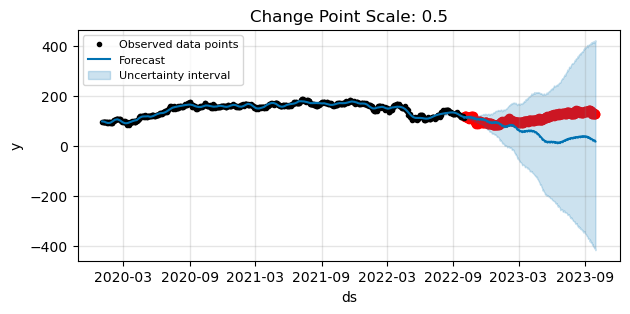

In [18]:
m1 = Prophet(changepoint_prior_scale=0.01)
forecast1 = m1.fit(df_train).predict(val_future)

m2 = Prophet(changepoint_prior_scale=0.05)
forecast2= m2.fit(df_train).predict(val_future)

m3 = Prophet(changepoint_prior_scale=0.1)
forecast3 = m3.fit(df_train).predict(val_future)

m4 = Prophet(changepoint_prior_scale=0.5)
forecast4 = m4.fit(df_train).predict(val_future)

fig, ax = plt.subplots(figsize=(7,3))
ax.scatter(df_val['ds'], df_val['y'], color='r')
fig = m1.plot(forecast1, ax)
plt.legend(loc = 2, prop={'size': 8})
plt.title('Change Point Scale: 0.01')

fig, ax = plt.subplots(figsize=(7,3))
ax.scatter(df_val['ds'], df_val['y'], color='r')
fig = m2.plot(forecast2, ax)
plt.title('Change Point Scale: 0.05')
plt.legend(loc = 2, prop={'size': 8})

fig, ax = plt.subplots(figsize=(7,3))
ax.scatter(df_val['ds'], df_val['y'], color='r')
fig = m3.plot(forecast3, ax)
plt.legend(loc = 2, prop={'size': 8})
plt.title('Change Point Scale: 0.1')

fig, ax = plt.subplots(figsize=(7,3))
ax.scatter(df_val['ds'], df_val['y'], color='r')
fig = m4.plot(forecast4, ax)
plt.legend(loc = 2, prop={'size': 8})
plt.title('Change Point Scale: 0.5')


### Seasonality

Seasonalities are estimated using a partial Fourier sum.
There is a parameter seasonality_prior_scale which similarly adjusts the extent to which the seasonality model will fit the data.

By default this parameter is 10, which provides very little regularization. Reducing this parameter dampens holiday effects

The additive model is useful when the seasonal variation is relatively constant over time. The multiplicative model is useful when the seasonal variation increases over time.

xtra regressors are put in the linear component of the model, so the underlying model is that the time series depends on the extra regressor as either an additive or multiplicative factor

## Cross Validation

In [19]:
from prophet.diagnostics import cross_validation
from prophet.diagnostics import performance_metrics

param_grid = {  
    'changepoint_prior_scale': [0.001, 0.01, 0.1, 0.2, 0.3, 0.4, 0.5],
    'seasonality_mode' : ['additive', 'multiplicative'],
    'seasonality_prior_scale': [0.01, 10.0]}

# Generate all combinations of parameters
all_params = [dict(zip(param_grid.keys(), v)) for v in itertools.product(*param_grid.values())]
rmses = []  # Store the RMSEs for each params here

# Use cross validation to evaluate all parameters
for params in all_params:
    
    # Fit model with given params
    m = Prophet(**params).fit(df_train) 
    
    # Perform cross validation
    df_cv = cross_validation(m, initial='366 days', period='45 days', horizon='90 days', parallel="processes")
    
    # Show performance metrics
    df_p = performance_metrics(df_cv, rolling_window=1)
    rmses.append(df_p['rmse'].values[0])

# Print parameter results
tuning_results = pd.DataFrame(all_params)
tuning_results['rmse'] = rmses
print(tuning_results)

17:28:10 - cmdstanpy - INFO - Chain [1] start processing
17:28:10 - cmdstanpy - INFO - Chain [1] done processing
17:28:10 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
17:28:10 - cmdstanpy - INFO - Chain [1] start processing
17:28:11 - cmdstanpy - INFO - Chain [1] done processing
17:28:14 - cmdstanpy - INFO - Chain [1] start processing
17:28:14 - cmdstanpy - INFO - Chain [1] done processing
17:28:14 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
17:28:14 - cmdstanpy - INFO - Chain [1] start processing
17:28:15 - cmdstanpy - INFO - Chain [1] done processing
17:28:19 - cmdstanpy - INFO - Chain [1] start processing
17:28:19 - cmdstanpy - INFO - Chain [1] done processing
17:28:19 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abn

    changepoint_prior_scale seasonality_mode  seasonality_prior_scale  \
0                     0.001         additive                     0.01   
1                     0.001         additive                    10.00   
2                     0.001   multiplicative                     0.01   
3                     0.001   multiplicative                    10.00   
4                     0.010         additive                     0.01   
5                     0.010         additive                    10.00   
6                     0.010   multiplicative                     0.01   
7                     0.010   multiplicative                    10.00   
8                     0.100         additive                     0.01   
9                     0.100         additive                    10.00   
10                    0.100   multiplicative                     0.01   
11                    0.100   multiplicative                    10.00   
12                    0.200         additive       

In [20]:
best_params = all_params[np.argmin(rmses)]
print(best_params)

{'changepoint_prior_scale': 0.5, 'seasonality_mode': 'multiplicative', 'seasonality_prior_scale': 0.01}


## Build best model

19:09:17 - cmdstanpy - INFO - Chain [1] start processing
19:09:18 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\zhesh\anaconda3\Lib\site-packages\prophet\plot.py:72: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  fcst_t = fcst['ds'].dt.to_pydatetime()
C:\Users\zhesh\anaconda3\Lib\site-packages\prophet\plot.py:73: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  ax.plot(m.history['ds'].dt.to_pydatetime(), m.history['y'], 'k.',


Text(0.5, 1.0, 'Change Point Scale: 0.5')

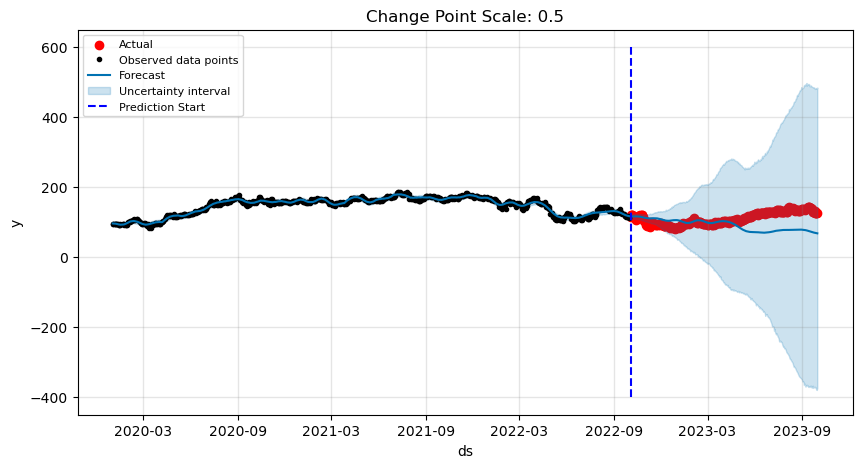

In [31]:
best_model = Prophet(changepoint_prior_scale = 0.5, seasonality_mode = 'multiplicative', seasonality_prior_scale = 0.01)

best_forcast = best_model.fit(df_train).predict(val_future)

fig, ax = plt.subplots(figsize=(10,5))
ax.scatter(df_val['ds'], df_val['y'], color='r', label = 'Actual')
fig = best_model.plot(best_forcast, ax)

plt.vlines(x=min(df_val['ds']).date(), ymin=-400, ymax=600, colors = 'b',
                       linestyles='dashed', label = 'Prediction Start')

plt.legend(loc = 2, prop={'size': 8})
plt.title('Change Point Scale: 0.5')


## Predict Future

In [22]:
# Include validation set for final training
df_full_training = df[df.index < val_test_split_date]
df_full_training = pd.DataFrame(df_full_training.Close)

df_full_training = df_full_training.reset_index() \
    .rename(columns={'Date':'ds',
                     'Close':'y'})

df_full_training['ds'] =  df_full_training['ds'].apply(lambda x: x.replace(tzinfo=None))

# Create and fit Final Model
final_model = Prophet(changepoint_prior_scale = 0.5, seasonality_mode = 'multiplicative', seasonality_prior_scale = 0.01)
final_model = final_model.fit(df_full_training)

# Create new empty dataframe for final forecast
test_future = final_model.make_future_dataframe(periods=250, freq='d', include_history=True)

# Predict final forecast
test_frcst = final_model.predict(test_future)

17:29:18 - cmdstanpy - INFO - Chain [1] start processing
17:29:19 - cmdstanpy - INFO - Chain [1] done processing


In [23]:
test_future

,ds
0,2020-01-02
1,2020-01-03
2,2020-01-06
3,2020-01-07
4,2020-01-08
...,...
1188,2024-06-01
1189,2024-06-02
1190,2024-06-03
1191,2024-06-04


Text(0.5, 1.0, 'Final Model')

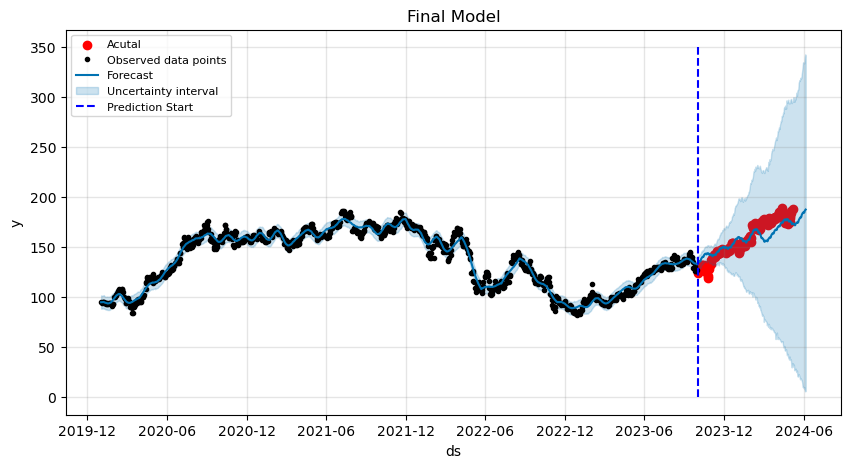

In [33]:
fig, ax = plt.subplots(figsize=(10,5))
ax.scatter(df_test['ds'], df_test['y'], color='r', label = 'Acutal')
fig = final_model.plot(test_frcst, ax)

plt.vlines(x=min(df_test['ds']).date(), ymin=0, ymax=350, colors = 'b',
                       linestyles='dashed', label = 'Prediction Start')

plt.legend(loc = 2, prop={'size': 8})
plt.title('Final Model')

In [25]:
test_future_2 = final_model.make_future_dataframe(periods=220, freq='d', include_history=False) 

future = final_model.predict(test_future_2)
future['diff'] = future['yhat'].diff()

        
    
future = future.dropna()

        # Find the prediction direction and create separate dataframes
future['direction'] = (future['diff'] > 0) * 1
        
        # Rename the columns for presentation
future = future.rename(columns={'ds': 'Date', 'yhat': 'estimate', 'diff': 'change', 
                                        'yhat_upper': 'upper', 'yhat_lower': 'lower'})
        
future_increase = future[future['direction'] == 1]
future_decrease = future[future['direction'] == 0]
        
        # Print out the dates
print('\nPredicted Increase: \n')
print(future_increase[['Date', 'estimate', 'change', 'upper', 'lower']])
        
print('\nPredicted Decrease: \n')
print(future_decrease[['Date', 'estimate', 'change', 'upper', 'lower']])


Predicted Increase: 

          Date    estimate    change       upper       lower
1   2023-10-01  132.991892  0.223498  139.491907  126.868136
2   2023-10-02  134.233553  1.241661  140.719698  127.754226
3   2023-10-03  134.755168  0.521615  141.021759  128.231433
4   2023-10-04  135.304327  0.549159  141.876079  128.602804
5   2023-10-05  135.733493  0.429166  141.789183  129.142333
..         ...         ...       ...         ...         ...
205 2024-04-22  177.982181  1.202633  305.334880   39.471910
206 2024-04-23  178.113596  0.131414  306.427300   34.852887
207 2024-04-24  178.130186  0.016590  303.800016   33.863811
212 2024-04-29  176.401041  0.825069  308.534064   30.369974
219 2024-05-06  173.736552  0.893027  309.993993   25.068804

[136 rows x 5 columns]

Predicted Decrease: 

          Date    estimate    change       upper       lower
7   2023-10-07  135.773417 -0.278318  142.299019  128.921122
14  2023-10-14  140.232137 -0.291079  146.764471  133.021560
20  2023-10-20 

C:\Users\zhesh\AppData\Local\Temp\ipykernel_11440\4194134842.py:9: FutureWarning: The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result
  ax.errorbar(future['Date'].dt.to_pydatetime(), future['estimate'],


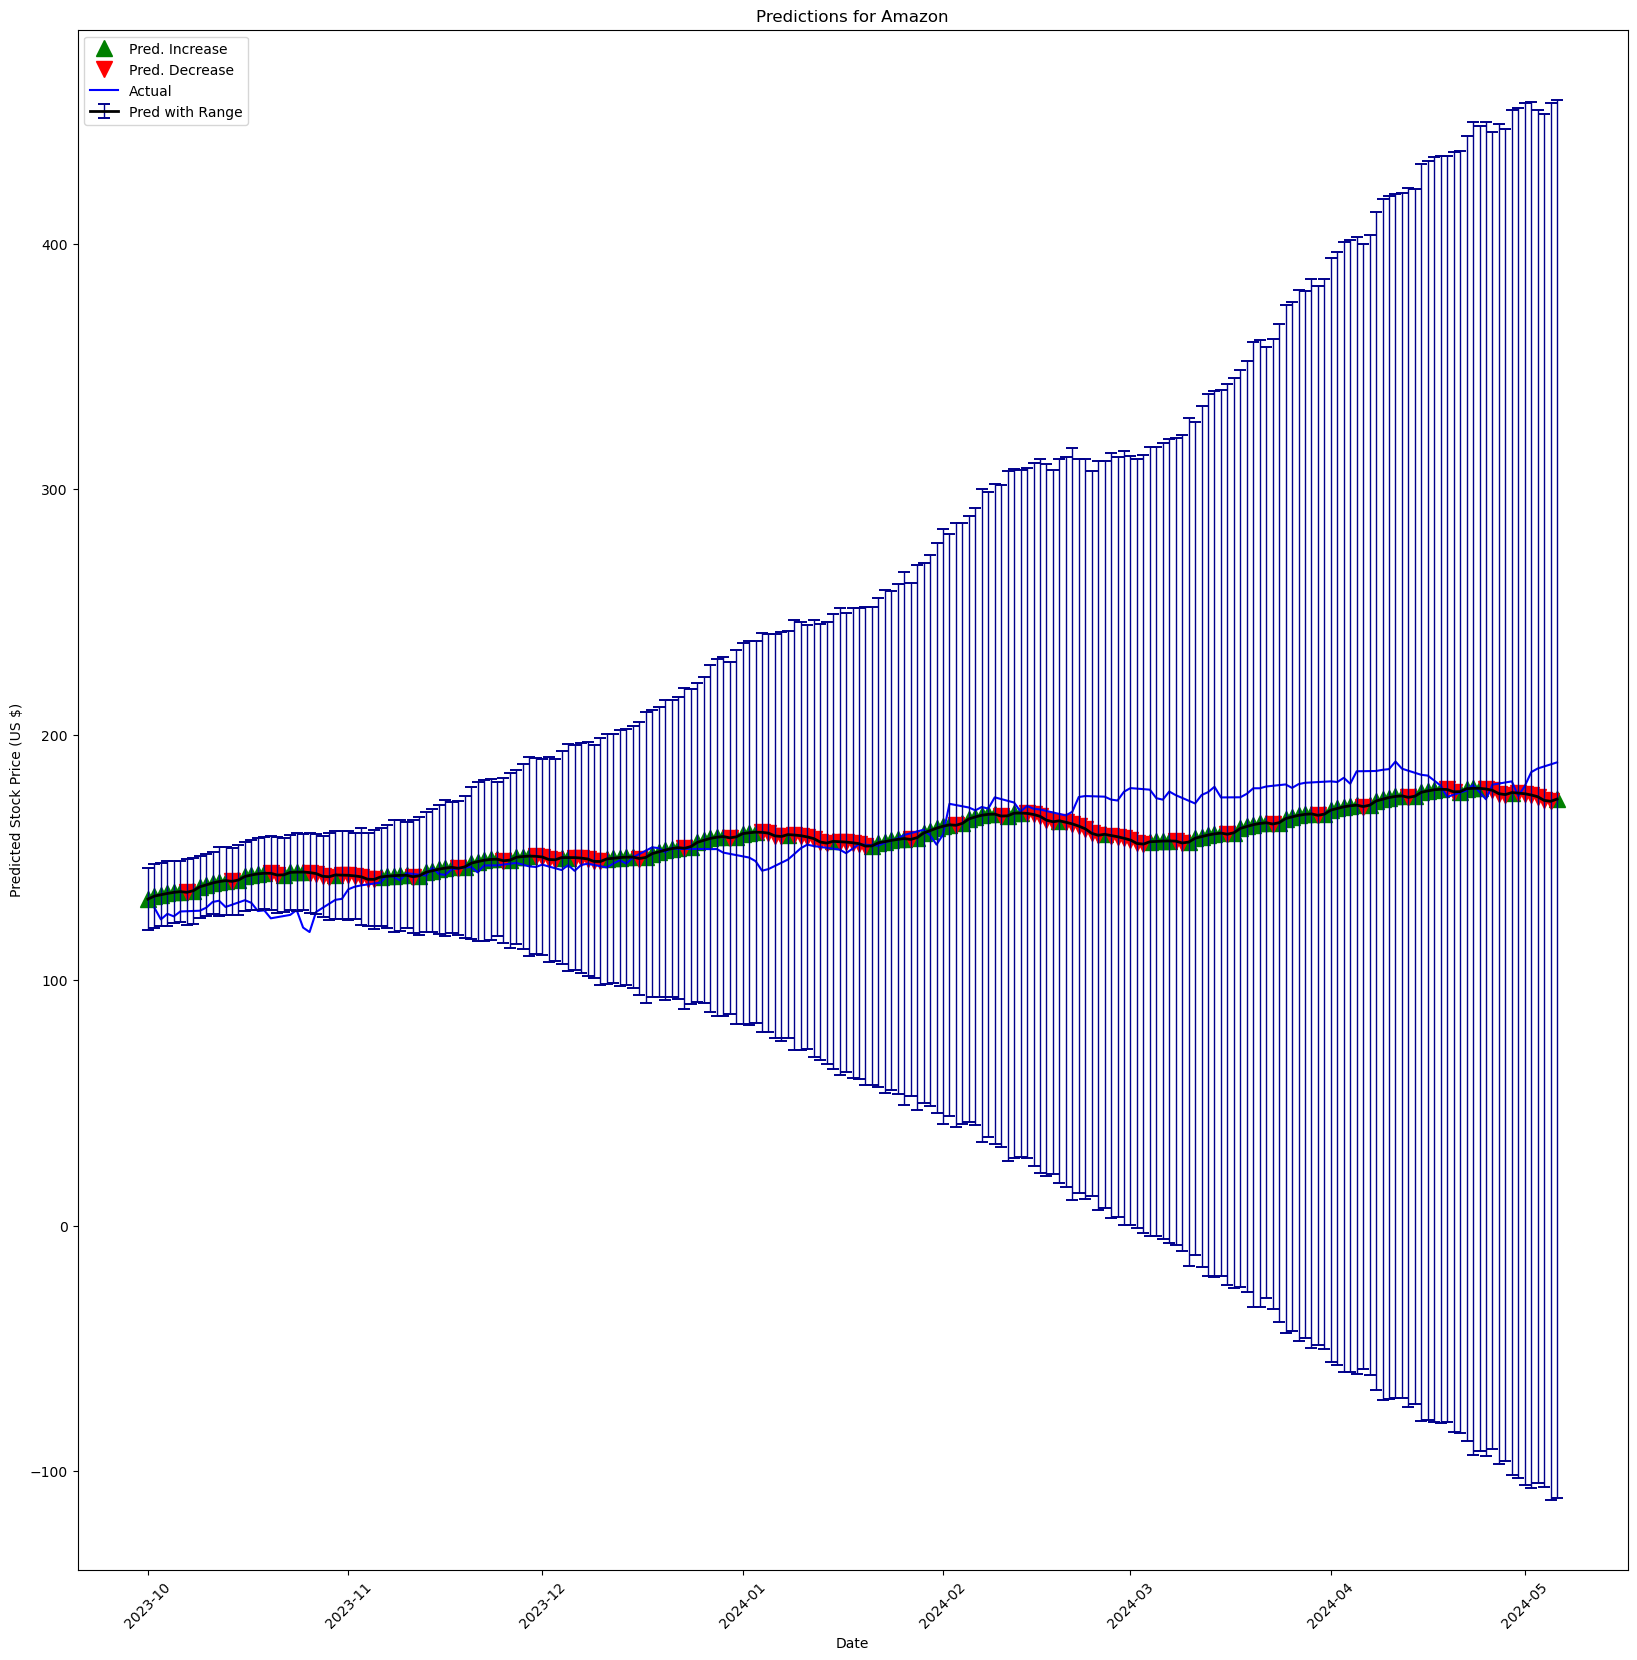

In [26]:
fig, ax = plt.subplots(1, 1, figsize=(20, 20))

# Plot the estimates
ax.plot(future_increase['Date'], future_increase['estimate'], 'g^', ms = 12, label = 'Pred. Increase')
ax.plot(future_decrease['Date'], future_decrease['estimate'], 'rv', ms = 12, label = 'Pred. Decrease')
ax.plot(df_test['ds'], df_test['y'], 'b', ms = 12, label = 'Actual')

# Plot errorbars
ax.errorbar(future['Date'].dt.to_pydatetime(), future['estimate'], 
                    yerr = future['upper'] - future['lower'], 
                    capthick=1.4, color = 'k',linewidth = 2,
                   ecolor='darkblue', capsize = 4, elinewidth = 1, label = 'Pred with Range')

# Plot formatting
plt.legend(loc = 2, prop={'size': 10});
plt.xticks(rotation = 45)
plt.ylabel('Predicted Stock Price (US $)');
plt.xlabel('Date'); 
plt.title('Predictions for Amazon');
plt.show()

In [38]:
df_error = pd.merge(df_test, test_frcst, on = 'ds', how = 'inner')

# Calculate mean absolute error
test_errors = abs(df_error['y'] - df_error['yhat'])
test_mean_error = np.mean(test_errors)

print('Mean Error:', test_mean_error)

Mean Error: 7.6004170626598535
